In [1]:
from data_loader import YahooStockDataSource
from trading_functions import MyTradingFunctions
from trading_params import MyTradingParams
from trading_system import TradingSystem
from backtest_evaluator import BacktestEvaluator
from plotting import plot_trade_signals
import matplotlib.pyplot as plt
import numpy as np


### Test the component of the trading system

In [2]:
# Define your test parameters
symbols = ['AAPL']
start_date = '2024-01-01'
end_date = '2024-12-31'

# Load the data
data_source = YahooStockDataSource(symbols, start_date, end_date)

# View the full dataframe (multi-indexed: [symbol, OHLCV])
data_source.data.head()

# Get just the Close prices for AAPL
close_prices = data_source.get_price_feature('AAPL', 'Close')
print("\nAAPL Close Prices:")
close_prices
close_prices.rolling(10)


AAPL Close Prices:


Rolling [window=10,center=False,axis=0,method=single]

In [3]:
# Create the trading function and params
tf = MyTradingFunctions()
params = MyTradingParams(tf)

# Check instruments
print("Symbols:", params.getSymbolsToTrade())

# Check date range
print("Start:", params.getStartDate())
print("End:", params.getEndDate())

# Check starting capital
print("Starting Capital:", params.getStartingCapital())

# Check if data loaded correctly
data_loader = params.getDataLoader()
data = data_loader.data
print("\nData columns:", data.columns.levels[0])  # Should list tickers
print("Sample data:\n", data.head())


Symbols: ['AAPL']
Start: 2024-01-01
End: 2024-12-31
Starting Capital: 1000

Data columns: Index(['AAPL'], dtype='object', name='Ticker')
Sample data:
 Ticker            AAPL                                              
Price             Open        High         Low       Close    Volume
Date                                                                
2024-01-02  186.033057  187.315366  182.792518  184.532074  82488700
2024-01-03  183.120571  184.770668  182.335277  183.150391  58414500
2024-01-04  181.062899  181.997291  179.800489  180.824341  71983600
2024-01-05  180.903872  181.669266  179.094727  180.098694  62303300
2024-01-08  181.003268  184.492330  180.416793  184.452560  59144500


In [4]:
close_prices = YahooStockDataSource(symbols, start_date, end_date).get_price_feature('AAPL')

for date in close_prices.index[:5]:
    slice_ = close_prices.loc[:date]
    prediction = tf.getPrediction(date, slice_)
    print(f"{date.date()} | Prediction: {prediction}")

2024-01-02 | Prediction: 1
2024-01-03 | Prediction: 0
2024-01-04 | Prediction: 0
2024-01-05 | Prediction: 0
2024-01-08 | Prediction: 0


### Simple Momentum Trading Strategy

In [2]:
class MomentumTradingFunctions:
    def __init__(self, short_window = 10, long_window = 30):
        self.short_window = short_window
        self.long_window = long_window
        self.in_position = 0  # 1 for long, -1 for short, 0 for flat
    
    def getSymbolsToTrade(self):
        return ['AAPL']
    
    def getPrediction(self, date, price_series):
        if len(price_series) < self.long_window:
            return 0.5  # not enough data, stay flat

        short_ma = price_series.rolling(self.short_window).mean().iloc[-1]
        long_ma = price_series.rolling(self.long_window).mean().iloc[-1]

        # Signal: go long if short MA crosses above long MA
        if short_ma > long_ma:
            if self.in_position != 1:
                self.in_position = 1
                return 1  # enter long
        elif short_ma < long_ma:
            if self.in_position != -1:
                self.in_position = -1
                return -1  # enter short
        else:
            if self.in_position != 0:
                self.in_position = 0
                return 0.5  # exit position

        return 0.5  # hold flat by default

In [3]:
# Instantiate strategy and params
momentum_tf = MomentumTradingFunctions(short_window=10, long_window=30)
momentum_params = MyTradingParams(momentum_tf)
momentum_ts = TradingSystem(momentum_params)

# Run backtest
momentum_ts.startTrading()

# Evaluate
momentum_results = momentum_ts.evaluate_performance()


🔔 Final Report 🔔
Final Cash: $1001.89
Final Positions:
  AAPL: 0 units x $251.92 = $0.00

Total Portfolio Value: $1001.89
Net PnL: $1.89

📝 Trade Log:
2024-02-13 | AAPL | SHORT @ $184.17
2024-02-14 | AAPL | BUY TO COVER @ $183.28
2024-05-03 | AAPL | BUY @ $182.52
2024-05-06 | AAPL | SELL TO CLOSE @ $180.86
2024-08-01 | AAPL | SHORT @ $217.63
2024-08-02 | AAPL | BUY TO COVER @ $219.12
2024-08-21 | AAPL | BUY @ $225.90
2024-08-22 | AAPL | SELL TO CLOSE @ $224.04
2024-09-16 | AAPL | SHORT @ $215.84
2024-09-17 | AAPL | BUY TO COVER @ $216.31
2024-09-27 | AAPL | BUY @ $227.29
2024-09-30 | AAPL | SELL TO CLOSE @ $232.49
2024-11-05 | AAPL | SHORT @ $222.96
2024-11-06 | AAPL | BUY TO COVER @ $222.23
2024-11-26 | AAPL | BUY @ $234.80
2024-11-27 | AAPL | SELL TO CLOSE @ $234.67

📊 Strategy Performance:
Total Return: 0.19%
CAGR:         0.19%
Sharpe Ratio: 0.65
Max Drawdown: 37.97%


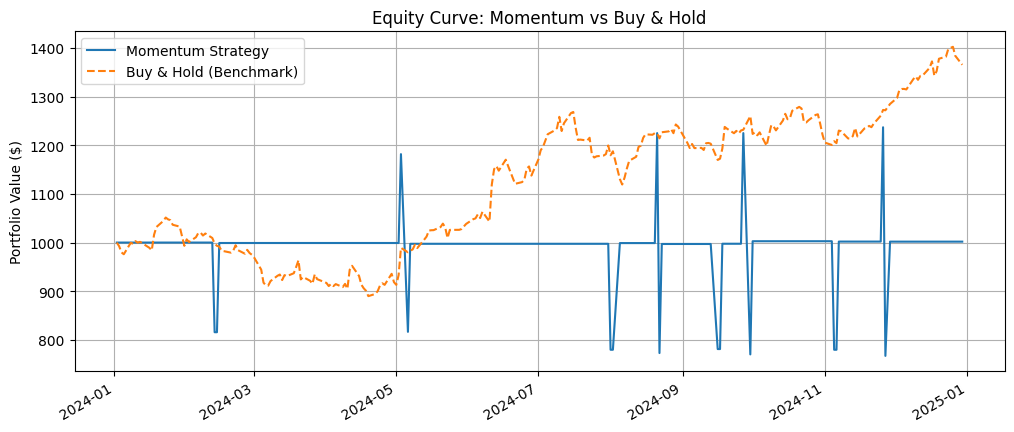

In [4]:
strategy = momentum_results['strategy']
benchmark = momentum_results['benchmark']

plt.figure(figsize=(12, 5))
strategy.plot(label='Momentum Strategy')
benchmark.plot(label='Buy & Hold (Benchmark)', linestyle='--')
plt.title('Equity Curve: Momentum vs Buy & Hold')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Evaluate and compare
evaluator = BacktestEvaluator(strategy, benchmark)
display(evaluator.get_metrics_df())

# # Plot drawdown
# evaluator.plot_drawdown()

# # Plot rolling Sharpe
# evaluator.plot_rolling_sharpe(window=60)

# # Plot rolling volatility
# evaluator.plot_rolling_volatility(window=60)

,Total Return,CAGR,Sharpe Ratio,Sortino Ratio,Max Drawdown
Strategy,0.19%,0.19%,0.65,0.61,37.97%
Benchmark,36.52%,36.69%,1.51,2.40,15.35%


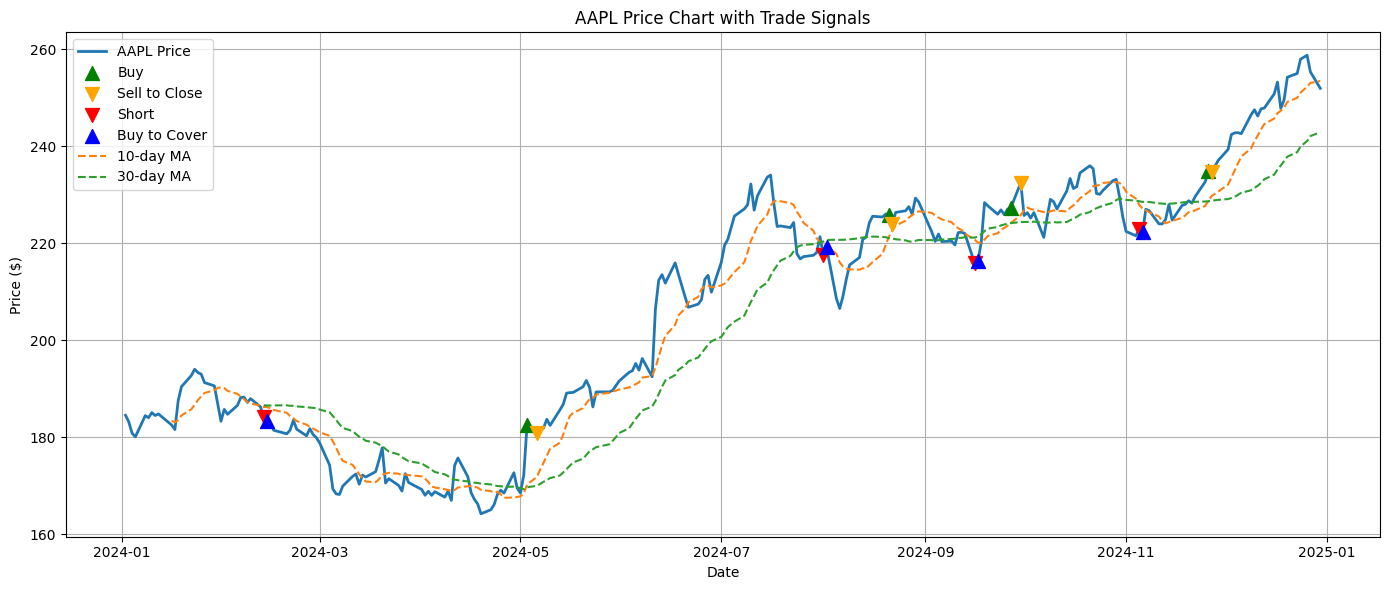

In [6]:
symbol = 'AAPL'
price_series = momentum_ts.dataLoader.get_price_feature(symbol, 'Close')
trades = momentum_ts.trade_log

# Optional indicators
ma10 = price_series.rolling(10).mean()
ma30 = price_series.rolling(30).mean()
indicators = {
    '10-day MA': ma10,
    '30-day MA': ma30
}

# Plot!
plot_trade_signals(price_series, trades, symbol, indicators)


### Hurst Exponent Strategy

In [7]:
class HurstMomentumStrategy:
    def __init__(self, short_mom=10, long_mom=30, ma_period=90):
        self.short_mom = short_mom
        self.long_mom = long_mom
        self.ma_period = ma_period
        self.in_position = 0  # 1 for long, -1 for short, 0 for flat

    def getSymbolsToTrade(self):
        return ['AAPL']

    def hurst_exponent(self, ts, lags=20):
        
        # interpretation of return value
        # hurst < 0.5 - input_ts is mean reverting
        # hurst = 0.5 - input_ts is effectively random/geometric brownian motion
        # hurst > 0.5 - input_ts is trending
        
        tau = []
        lagvec = []
        ts = ts.dropna().values  # Ensure no NaNs

        if len(ts) < lags:
            return 0.5  # Not enough data

        for lag in range(2, lags):
            pp = np.subtract(ts[lag:], ts[:-lag])
            lagvec.append(lag)
            tau.append(np.sqrt(np.std(pp)))

        m = np.polyfit(np.log10(lagvec), np.log10(tau), 1)
        hurst = m[0] * 2
        return hurst

    def getPrediction(self, date, price_series):
        if len(price_series) < self.ma_period:
            return 0.5  # Not enough data, stay flat

        short_mom = price_series.pct_change(self.short_mom).iloc[-1]
        long_mom = price_series.pct_change(self.long_mom).iloc[-1]

        ma_series = price_series.rolling(self.ma_period).mean()
        hurst = self.hurst_exponent(ma_series.dropna())

        if hurst > 0.5:
            if short_mom > 0 and long_mom > 0:
                if self.in_position != 1:
                    self.in_position = 1
                    return 1  # Go long
            elif short_mom < 0 and long_mom < 0:
                if self.in_position != -1:
                    self.in_position = -1
                    return -1  # Go short
            else:
                if self.in_position != 0:
                    self.in_position = 0
                    return 0.5  # Exit to flat
        else:
            if self.in_position != 0:
                self.in_position = 0
                return 0.5  # Exit to flat

        return 0.5  # Hold flat by default
        
    def getIndicatorSeries(self, price_series):
        """Optional: Return indicators for plotting"""
        return {
            f'{self.short_mom}-day Momentum': price_series.pct_change(self.short_mom),
            f'{self.long_mom}-day Momentum': price_series.pct_change(self.long_mom),
            f'{self.ma_period}-day MA': price_series.rolling(self.ma_period).mean()
        }


In [8]:
# Instantiate strategy and params
hurst_tf = HurstMomentumStrategy(short_mom=10, long_mom=30)
hurst_params = MyTradingParams(hurst_tf)
hurst_ts = TradingSystem(hurst_params)

# Run backtest
hurst_ts.startTrading()

# Evaluate
hurst_results = hurst_ts.evaluate_performance()


🔔 Final Report 🔔
Final Cash: $1012.55
Final Positions:
  AAPL: 0 units x $251.92 = $0.00

Total Portfolio Value: $1012.55
Net PnL: $12.55

📝 Trade Log:
2024-06-25 | AAPL | BUY @ $208.37
2024-06-26 | AAPL | SELL TO CLOSE @ $212.54
2024-07-01 | AAPL | BUY @ $216.02
2024-07-02 | AAPL | SELL TO CLOSE @ $219.53
2024-08-06 | AAPL | SHORT @ $206.54
2024-08-07 | AAPL | BUY TO COVER @ $209.12
2024-08-13 | AAPL | BUY @ $220.78
2024-08-14 | AAPL | SELL TO CLOSE @ $221.23
2024-08-15 | AAPL | BUY @ $224.23
2024-08-16 | AAPL | SELL TO CLOSE @ $225.55
2024-08-29 | AAPL | BUY @ $229.29
2024-08-30 | AAPL | SELL TO CLOSE @ $228.50
2024-09-03 | AAPL | SHORT @ $222.28
2024-09-04 | AAPL | BUY TO COVER @ $220.37
2024-09-16 | AAPL | SHORT @ $215.84
2024-09-17 | AAPL | BUY TO COVER @ $216.31
2024-09-19 | AAPL | BUY @ $228.37
2024-09-20 | AAPL | SELL TO CLOSE @ $227.70
2024-10-03 | AAPL | SHORT @ $225.17
2024-10-04 | AAPL | BUY TO COVER @ $226.30
2024-10-07 | AAPL | SHORT @ $221.20
2024-10-08 | AAPL | BUY TO 

/var/folders/l5/2302s0j90898y2c73n3g1wmr0000gn/T/ipykernel_3745/1016832720.py:30: RuntimeWarning: divide by zero encountered in log10
  m = np.polyfit(np.log10(lagvec), np.log10(tau), 1)


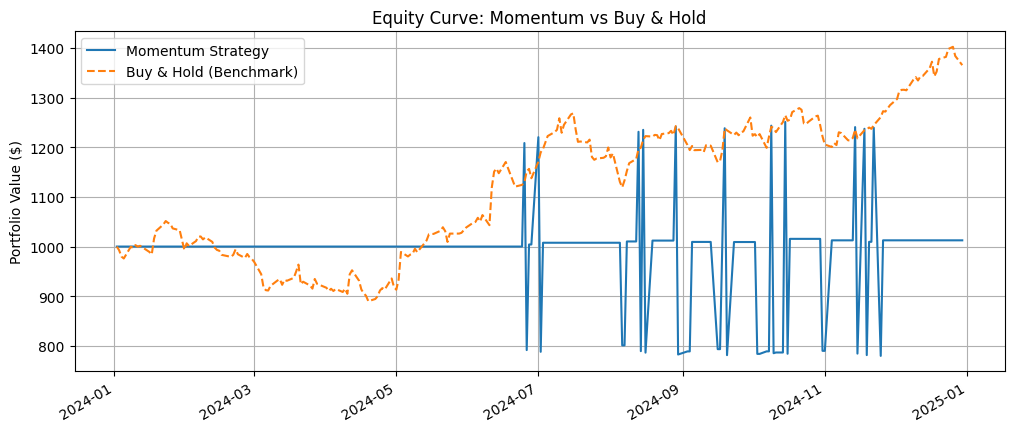

In [9]:
strategy = hurst_results['strategy']
benchmark = hurst_results['benchmark']

plt.figure(figsize=(12, 5))
strategy.plot(label='Momentum Strategy')
benchmark.plot(label='Buy & Hold (Benchmark)', linestyle='--')
plt.title('Equity Curve: Momentum vs Buy & Hold')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Evaluate and compare
evaluator = BacktestEvaluator(strategy, benchmark)
display(evaluator.get_metrics_df())

,Total Return,CAGR,Sharpe Ratio,Sortino Ratio,Max Drawdown
Strategy,1.26%,1.26%,1.03,1.95,37.65%
Benchmark,36.52%,36.69%,1.51,2.40,15.35%


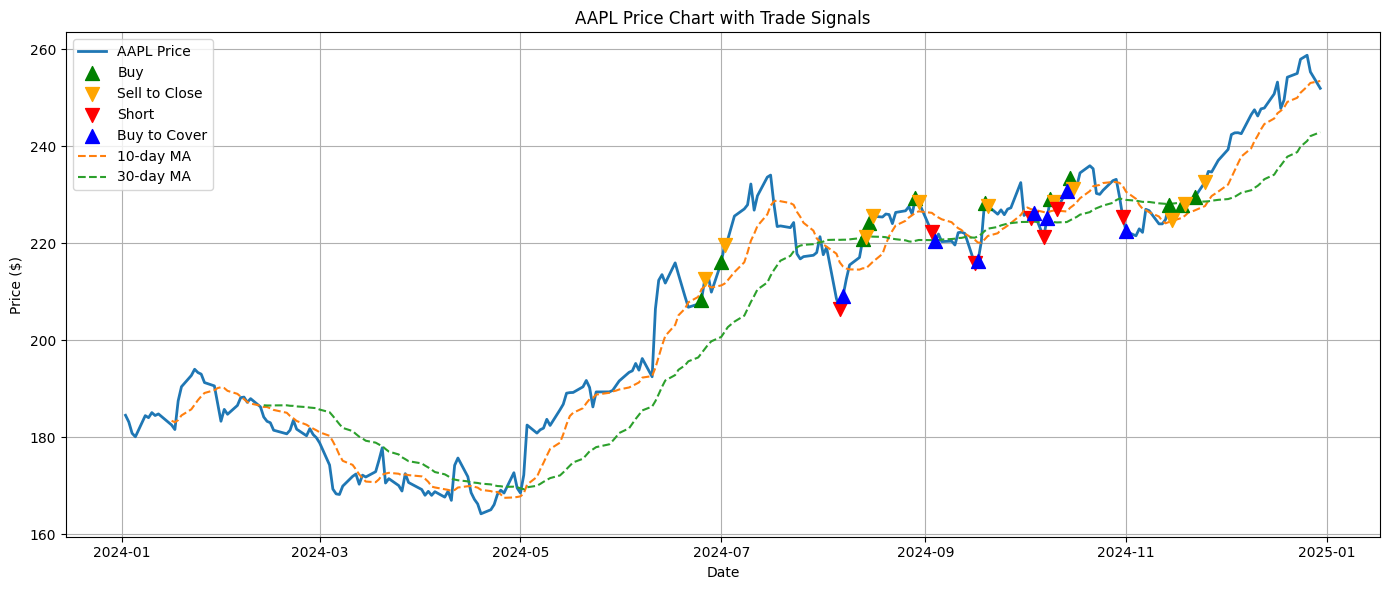

In [11]:
symbol = 'AAPL'
price_series = hurst_ts.dataLoader.get_price_feature(symbol, 'Close')
trades = hurst_ts.trade_log

# Optional indicators
ma10 = price_series.rolling(10).mean()
ma30 = price_series.rolling(30).mean()
indicators = {
    '10-day MA': ma10,
    '30-day MA': ma30
}

# Plot!
plot_trade_signals(price_series, trades, symbol, indicators)
